In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = "/content/drive/MyDrive/dataset-resized/"

In [ ]:
files_papaya = []
# r=root, d=directories, f = files
for r, d, f in os.walk(root + "papaya"):
    for file in f:
        files_healthy.append(file)
files_papaya.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [ ]:
X = []
Y = []
for image in files_papaya[0:700]:
    img = Image.open(root + 'papaya/' + image)
    img.load()
    data = np.asarray(img)
    data = cv2.cvtColor(data, cv2.COLOR_BGRA2BGR)
    X.append(data)
    Y.append(0)

In [ ]:
files_pepper = []
# r=root, d=directories, f = files
for r, d, f in os.walk(root + "pepper"):
    for file in f:
        files_pepper.append(file)
files_pepper.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [ ]:
for image in files_pepper[0:700]:
    img = Image.open(root + 'pepper/' + image)
    img.load()
    data = np.asarray(img)
    data = cv2.cvtColor(data, cv2.COLOR_BGRA2BGR)
    X.append(data)
    Y.append(1)

In [ ]:
# for image in files_papaya[300:500]:
#     img = Image.open(root + 'papaya/' + image)
#     img.load()
#     data = np.asarray(img)
#     data = cv2.cvtColor(data, cv2.COLOR_BGRA2BGR)
#     X.append(data)
#     Y.append(0)

# for image in files_pepper[300:500]:
#     img = Image.open(root + 'pepper/' + image)
#     img.load()
#     data = np.asarray(img)
#     data = cv2.cvtColor(data, cv2.COLOR_BGRA2BGR)
#     X.append(data)
#     Y.append(1)

In [ ]:
import sklearn
X, Y = sklearn.utils.shuffle(X, Y)

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape,Y.shape

((1400, 400, 400, 3), (1400,))

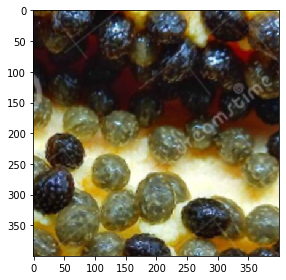

This is: Papaya


In [ ]:
from skimage.io import imshow
import matplotlib.pyplot as plt

idx = 300

imshow(np.squeeze(X[idx,:,:,:]))
plt.show()

labels = ['Papaya','Pepper']
print ('This is:',labels[int(Y[idx])])

In [ ]:
from tensorflow.keras.layers import Input

# We have 2 inputs, 1 for each picture
left_input = Input((400,400,3))
right_input = Input((400,400,3))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Conv2D, Flatten, Dense,Dropout
from keras.layers.normalization import BatchNormalization
# We will use 2 instances of 1 network for this task
base_network = Sequential([
    Conv2D(5,3, input_shape=(400,400,3)),
    BatchNormalization(),
    Activation('tanh'),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(5,3),
    BatchNormalization(),
    Activation('tanh'),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(7,2),
    BatchNormalization(),
    Activation('tanh'),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(7,2),
    BatchNormalization(),
    Activation('tanh'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(18)
    # Activation('sigmoid')
])

In [ ]:
processed_a = base_network(left_input)
processed_b = base_network(right_input)

In [ ]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([processed_a, processed_b])

In [ ]:
from tensorflow.keras.models import Model

prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(0.001, decay=2.5e-4)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

In [ ]:
np.unique(Y,return_counts=True)

(array([0, 1]), array([700, 700]))

In [ ]:
import random

# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X[:1000],1000)
label_list = np.split(Y[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1)
        else:# Not the same
            targets.append(0)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

pepper_img = X[500]
test_left = []
test_right = []
test_targets = []

for i in range(Y.shape[0]-1000):
    test_left.append(pepper_img)
    test_right.append(X[i+1000])
    test_targets.append(Y[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

In [ ]:
np.unique(targets,return_counts=True)

(array([0, 1]), array([2551, 2449]))

In [ ]:
np.unique(test_targets,return_counts=True)

(array([0, 1]), array([198, 202]))

In [ ]:
print(len(left_input), len(right_input), len(targets))

5000 5000 5000


Index is: 2276
SAME 1


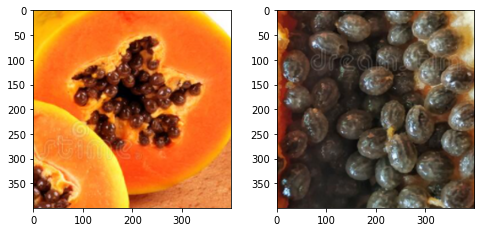

In [ ]:
fig = plt.figure(figsize=(8, 8))
#imshow(np.squeeze(left_input[10]))
#plt.show()
inx = int(np.random.rand(1,1)*3000)
fig.add_subplot(2, 2, 1)
plt.imshow(np.squeeze(left_input[inx]))
fig.add_subplot(2, 2, 2)
plt.imshow(np.squeeze(right_input[inx]))
print("Index is:", inx)
s_inx = "SAME" if targets[inx] else "Different"
print(s_inx, targets[inx])

In [ ]:
print(len(test_left), len(test_right), len(test_targets))

400 400 400


Index is: 269
SAME 1


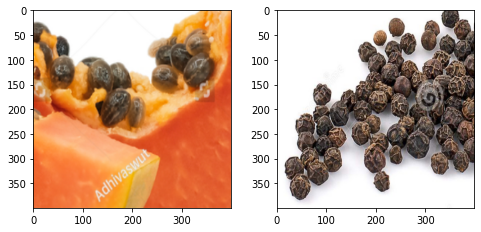

In [ ]:
fig = plt.figure(figsize=(8, 8))
#imshow(np.squeeze(left_input[10]))
#plt.show()
dnx = int(np.random.rand(1,1)*400)
fig.add_subplot(2, 2, 1)
plt.imshow(np.squeeze(test_left[dnx]))
fig.add_subplot(2, 2, 2)
plt.imshow(np.squeeze(test_right[dnx]))
print("Index is:", dnx)
s_dnx = "SAME" if test_targets[dnx] else "Different"
print(s_dnx, test_targets[dnx])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")
generator=aug.flow([left_input,right_input],targets,batch_size=8)

In [ ]:
history= siamese_net.fit(
    generator,
    # [left_input,right_input], targets,
          # batch_size = 8,
          epochs=30,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))

Epoch 1/30
157/157 [==============================] - 48s 100ms/step - loss: 0.8532 - accuracy: 0.4904 - val_loss: 0.6639 - val_accuracy: 0.6125
Epoch 2/30
157/157 [==============================] - 15s 95ms/step - loss: 0.7992 - accuracy: 0.5058 - val_loss: 0.6607 - val_accuracy: 0.5925
Epoch 3/30
157/157 [==============================] - 15s 96ms/step - loss: 0.7742 - accuracy: 0.5034 - val_loss: 0.6288 - val_accuracy: 0.5675
Epoch 4/30
157/157 [==============================] - 15s 97ms/step - loss: 0.7378 - accuracy: 0.5266 - val_loss: 0.5754 - val_accuracy: 0.6175
Epoch 5/30
157/157 [==============================] - 15s 98ms/step - loss: 0.6908 - accuracy: 0.5740 - val_loss: 0.5041 - val_accuracy: 0.7250
Epoch 6/30
157/157 [==============================] - 15s 98ms/step - loss: 0.6283 - accuracy: 0.6594 - val_loss: 0.4690 - val_accuracy: 0.8175
Epoch 7/30
157/157 [==============================] - 15s 99ms/step - loss: 0.5477 - accuracy: 0.7318 - val_loss: 0.4444 - val_accuracy

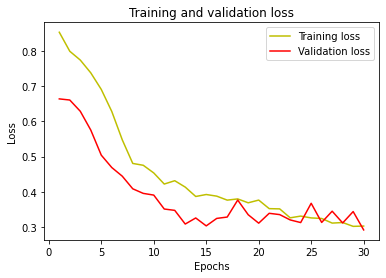

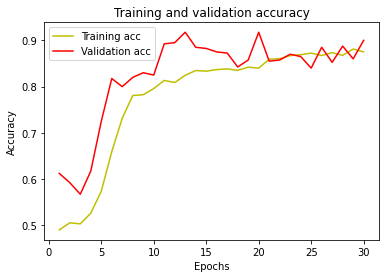

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('Loss.png',bbox_inches='tight')
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('Accuracy.png',bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report : \n",classification_report(test_targets,siamese_net.predict([test_left,test_right]).round()))

Classification Report : 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91       198
           1       1.00      0.80      0.89       202

    accuracy                           0.90       400
   macro avg       0.92      0.90      0.90       400
weighted avg       0.92      0.90      0.90       400



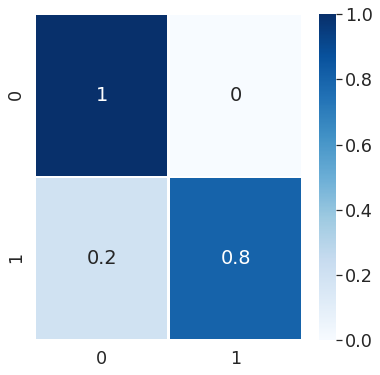

In [ ]:
cm = confusion_matrix(test_targets, siamese_net.predict([test_left,test_right]).round())
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True,
            cmap='Blues',
            # fmt='d',
            linewidths=1.5, ax=ax)
# plt.savefig('CNN.png', dpi=100)